# Visualizing Subject Trajectories

This document demonstrates how we can use `tabluence` to  effectively visualize  the trajectory of a subject through time.

### Preparations

In [1]:
import os
import sys
sys.path.append(os.path.abspath('../..'))
# from tabluence.data.api.smartwatch.utilities.preparations import *
import pandas
import plotly_express as px
import numpy
from tabluence.data.api.smartwatch.data_manager import SmartwatchDataManager
from tabluence.data.api.smartwatch.utilities.timestamp import *
from plotly.subplots import make_subplots

def change_df(df, value_column):
    df = df.copy()
    df['utc_date'] = df['utc_timestamp'].apply(lambda x: get_utc_date_from_utc_timestamp(x))
    df = df.loc[:, ['utc_timestamp', 'utc_date', value_column]]
    df.rename({value_column: 'value'}, inplace=True, axis=1, errors='raise')
    df['signal'] = value_column[:-len('_tsvalue')]
    return df

import logging
logging.basicConfig(format='%(asctime)s - %(name)s - %(levelname)s - %(message)s', level=logging.DEBUG)
logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)

Let's  prepare the data manager to get access to the data:

In [2]:
data_manager = SmartwatchDataManager(
        root_dir='../../resources/warrior_wellness/Analysis/local_repo/',
        subject_id_list=[f'SWS_{i:02d}' for i in range(0,15)],
        cache_filepath=None
    )

Pick a subject to demonstrate:

In [11]:
subject_id = 'SWS_04'

## Supervision signals

In what follows, we  get the signals throughout the entire time-range of the subject, as well as the subject-specific functions built using the feedback we received from them.

In [12]:
signals = data_manager.get_subject_signals_for_utc_timestamp_range(subject_id, data_manager.get_utc_timestamp_range_for_subject(subject_id))
subject_overall_stress_function = data_manager.get_subject_general_stress_function(subject_id=subject_id)
subject_specific_stress_function = data_manager.get_subject_specific_stress_function(subject_id=subject_id, stress_types=["induced", "general", "interpersonal"])
df = pandas.concat([
    change_df(signals['daily'], 'heart_rate_tsvalue'),
    change_df(signals['respiration'], 'epoch_to_breath_tsvalue'),
    change_df(signals['stress'], 'stress_level_tsvalue'),
    change_df(signals['pulseOx'], 'spo2_tsvalue'),

])

t_start, t_end = data_manager.get_utc_timestamp_range_for_subject(subject_id)

utc_timestamp_vals = numpy.linspace(t_start, t_end, 10000)
utc_date_vals = [get_utc_date_from_utc_timestamp(x) for x in numpy.linspace(t_start, t_end, 10000).tolist()]
specific_stress_vals = subject_specific_stress_function(utc_timestamp_vals)
overall_stress_vals = subject_overall_stress_function(utc_timestamp_vals)

df = pandas.concat([
    df,
    pandas.DataFrame({
        'utc_timestamp': utc_timestamp_vals,
        'utc_date': utc_date_vals,
        'value': overall_stress_vals,
        'signal': 'overall_stress'}),
    pandas.DataFrame({
        'utc_timestamp': utc_timestamp_vals,
        'utc_date': utc_date_vals,
        'value': specific_stress_vals['general'],
        'signal': 'specific_stress: <general>'}),
    pandas.DataFrame({
        'utc_timestamp': utc_timestamp_vals,
        'utc_date': utc_date_vals,
        'value': specific_stress_vals['induced'],
        'signal': 'specific_stress: <induced>'}),
    pandas.DataFrame({
        'utc_timestamp': utc_timestamp_vals,
        'utc_date': utc_date_vals,
        'value': specific_stress_vals['interpersonal'],
        'signal': 'specific_stress: <interpersonal>'}),
])



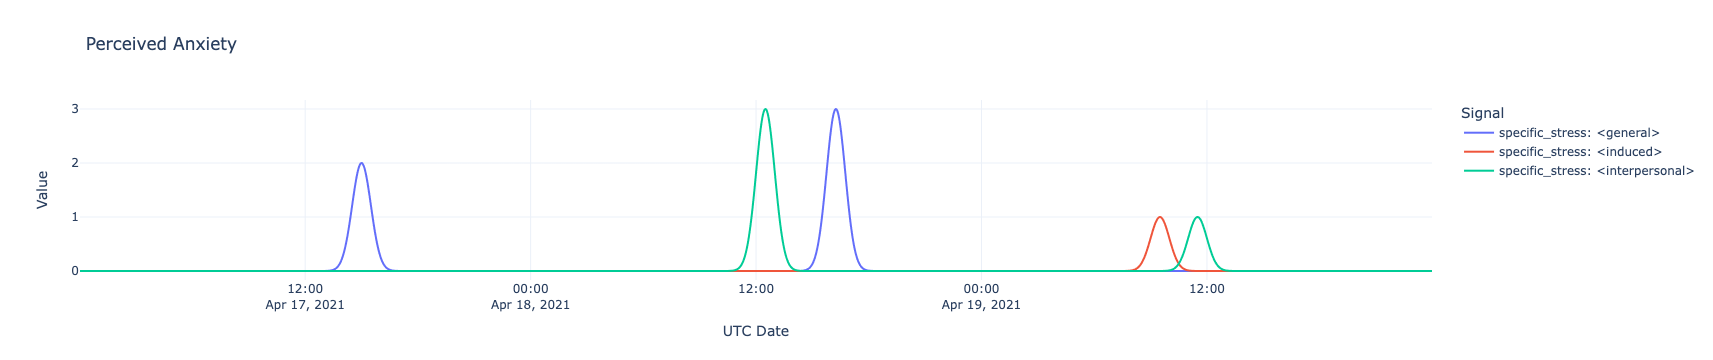

In [27]:
tmp_df = df[(df.utc_date >= '2021-04-17') & (df.utc_date < '2021-04-20')].copy()
tmp_df = tmp_df[~tmp_df.signal.isin(['heart_rate', 'epoch_to_breath', 'stress_level', 'spo2', 'overall_stress'])]
fig = px.line(
    tmp_df, 
    x='utc_date', 
    hover_data=['utc_date', 'utc_timestamp'], 
    color='signal', 
    y='value', 
    title="Perceived Anxiety", 
    labels=dict(
        utc_date="UTC Date",
        utc_timestamp="UTC Timestamp",
        signal="Signal",
        value="Value"
    ),
    template='plotly_white'
)

fig.write_image("./figures/perceived_anxiety.pdf", scale=1, width=1000, height=300)
fig.show()

## Observations

Visualizing the physiological readings:

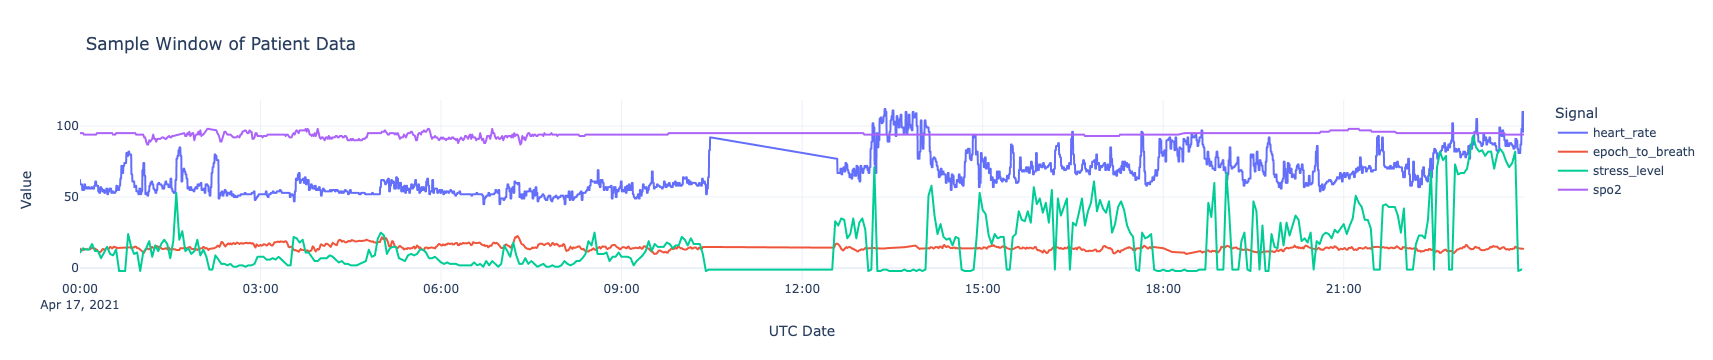

In [32]:
tmp_df = df[(df.utc_date >= '2021-04-17') & (df.utc_date < '2021-04-18')].copy()
tmp_df = tmp_df[tmp_df.signal.isin(['heart_rate', 'epoch_to_breath', 'stress_level', 'spo2'])]
fig = px.line(
    tmp_df, 
    x='utc_date', 
    hover_data=['utc_date', 'utc_timestamp'], 
    color='signal', 
    y='value', 
    title="Sample Window of Patient Data", 
    labels=dict(
        utc_date="UTC Date",
        utc_timestamp="UTC Timestamp",
        signal="Signal",
        value="Value"
    ),
    template='plotly_white'
)

fig.write_image("./figures/sample_window.pdf", scale=1, width=1000, height=300)
fig.show()